In [25]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = table[0]['Symbol'].to_list()
sp500_list = [s.replace('.', '-') for s in sp500_list]
len(sp500_list)

503

In [27]:
table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
nasdaq_list = table[4]['Ticker'].to_list()
nasdaq_list = [s.replace('.', '-') for s in nasdaq_list]
len(nasdaq_list)

102

In [28]:
table = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
dj_list = table[1]['Symbol'].to_list()
dj_list = [s.replace('.', '-') for s in dj_list]
len(dj_list)

30

In [29]:
stock_pool = list(set(sp500_list).union(set(nasdaq_list)).union(set(dj_list)))
print(len(stock_pool))
year = '2022'
# start, end = year+'-01-01', year+'-12-31'
start, end = year+'-01-01', year+'-10-31'

526


In [30]:
# from main import stocks_norm_return
# norm_return = stocks_norm_return(stock_pool, start, end, dropna=True)
# norm_return.to_csv(f'all_stocks_return_{start}_{end}.csv', index=True)

In [31]:
# spy = yf.download("SPY", start=start, end=end)
# spy.to_csv(f'spy_{start}_{end}.csv', index=True)

In [32]:
norm_return = pd.read_csv(f'all_stocks_return_{start}_{end}.csv', index_col=0)
norm_return.index = pd.to_datetime(norm_return.index)
spy = pd.read_csv(f'spy_{start}_{end}.csv', index_col=0)
spy.index = pd.to_datetime(spy.index)

In [33]:
from main import MC_portfolio

p = MC_portfolio(norm_return, 1e6)
p.mc_stock_choice(iter=20000, k=100, history=True)
p.best_sharpe, p.best_pnl, p.best_stocks

(-0.5490120610929936,
 0.9774603453207173,
 array(['CHD', 'ADM', 'CSCO', 'RF', 'AVY', 'TRMB', 'SLB', 'UNP', 'DVA',
        'JKHY', 'NWL', 'GD', 'MSCI', 'FBHS', 'DXCM', 'AJG', 'OTIS', 'CMA',
        'IQV', 'MOS', 'WRB', 'WMT', 'TMO', 'IDXX', 'CSGP', 'EPAM', 'ENPH',
        'MCO', 'XOM', 'CBOE', 'ROL', 'ROK', 'IP', 'TPR', 'TAP', 'DVN',
        'FTNT', 'ADP', 'RTX', 'EVRG', 'LCID', 'WYNN', 'FDS', 'ED', 'CI',
        'TRV', 'PKG', 'CMI', 'CNC', 'CMG', 'CHTR', 'PNC', 'LLY', 'HUM',
        'ETSY', 'WY', 'TDG', 'AMGN', 'DTE', 'APH', 'TXN', 'DRI', 'CVX',
        'HIG', 'VMC', 'EOG', 'NCLH', 'IBM', 'PGR', 'WELL', 'FANG', 'TEAM',
        'HCA', 'STZ', 'GLW', 'CFG', 'MET', 'GPC', 'LEN', 'MPC', 'DFS',
        'DD', 'MKC', 'PNW', 'NRG', 'CMS', 'PG', 'SRE', 'DUK', 'TFX', 'TER',
        'K', 'AFL', 'LH', 'HST', 'FAST', 'BRK-B', 'BALL', 'SPG', 'PFG'],
       dtype=object))

In [34]:
hist = {}
for idx in np.argpartition(p.history_sharpe, -100)[-100:]:
    for s in p.history_stocks[idx]:
        if hist.get(s, -1) == -1:
            hist[s] = 1
        else:
            hist[s] += 1
hist_df = pd.DataFrame(hist.items(), columns=['stock', 'freq']).sort_values('freq')

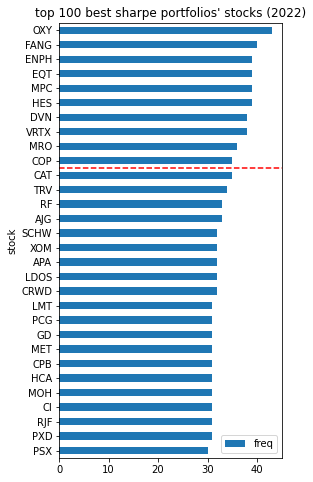

In [35]:
topk, bestk = 30, 10
ax = hist_df.tail(topk).plot.barh(x='stock', figsize=(4,8), title=f"top 100 best sharpe portfolios' stocks ({year})")
ax.axhline(topk-bestk-0.5, c='red', ls='--')
plt.show()

In [36]:
my_best_stocks1 = hist_df.tail(bestk).stock.values
f_weights1 = (hist_df.tail(bestk).freq / hist_df.tail(bestk).freq.sum()).values
p.mc_weight_choice(my_best_stocks1, iter=5000, by='sharpe')
mc_weights1 = p.best_weights

Text(0.5, 1.0, 'Weights of each component (Sharpe)')

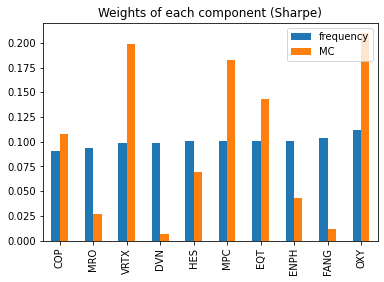

In [37]:
pd.DataFrame({'frequency': f_weights1, 'MC': mc_weights1}, index=my_best_stocks1).plot.bar()
plt.title('Weights of each component (Sharpe)')

In [38]:
hist = {}
for idx in np.argpartition(p.history_pnl, -100)[-100:]:
    for s in p.history_stocks[idx]:
        if hist.get(s, -1) == -1:
            hist[s] = 1
        else:
            hist[s] += 1
hist_df = pd.DataFrame(hist.items(), columns=['stock', 'freq']).sort_values('freq')

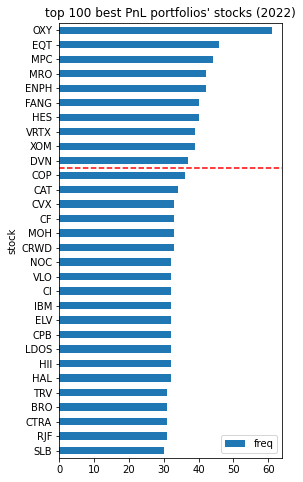

In [39]:
ax = hist_df.tail(topk).plot.barh(x='stock', figsize=(4,8), title=f"top 100 best PnL portfolios' stocks ({year})")
ax.axhline(topk-bestk-0.5, c='red', ls='--')
plt.show()

In [40]:
my_best_stocks2 = hist_df.tail(bestk).stock.values
f_weights2 = (hist_df.tail(bestk).freq / hist_df.tail(bestk).freq.sum()).values
p.mc_weight_choice(my_best_stocks2, iter=5000, by='pnl')
mc_weights2 = p.best_weights

Text(0.5, 1.0, 'Weights of each component (PnL)')

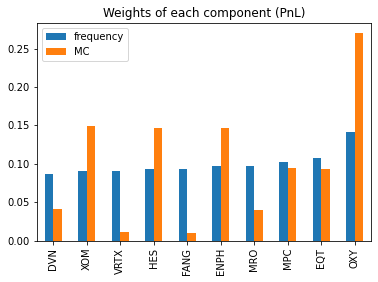

In [41]:
pd.DataFrame({'frequency': f_weights2, 'MC': mc_weights2}, index=my_best_stocks2).plot.bar()
plt.title('Weights of each component (PnL)')

Text(0, 0.5, 'Percentage Position')

<Figure size 1152x576 with 0 Axes>

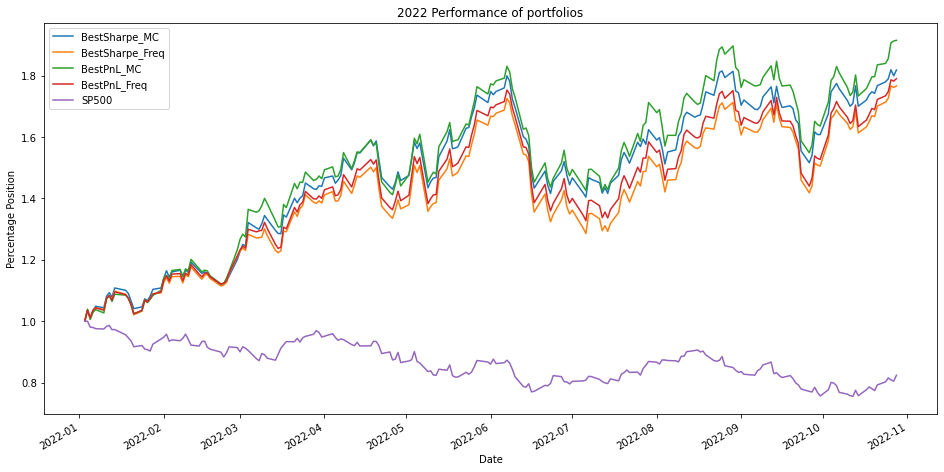

In [42]:
from main import build_portfolio, init_weight_choice
fig = plt.figure(figsize=(16,8))

bsharpe_mc = build_portfolio(norm_return, 1e6, my_best_stocks1 , mc_weights1)
bsharpe_f = build_portfolio(norm_return, 1e6, my_best_stocks1 , f_weights1)

bpnl_mc = build_portfolio(norm_return, 1e6, my_best_stocks2 , mc_weights2)
bpnl_f = build_portfolio(norm_return, 1e6, my_best_stocks2 , f_weights2)

spy_PerPos = spy['Adj Close'] / spy['Adj Close'].iloc[0]

super_df = pd.concat([bsharpe_mc.PercentagePos, bsharpe_f.PercentagePos, bpnl_mc.PercentagePos, bpnl_f.PercentagePos, spy_PerPos], axis=1)
super_df.columns = ['BestSharpe_MC', 'BestSharpe_Freq', 'BestPnL_MC', 'BestPnL_Freq', 'SP500']
super_df.plot(figsize=(16,8))
plt.title('2022 Performance of portfolios')
plt.ylabel('Percentage Position')

In [43]:
bsharpe_f.DailyPercentageReturn.min(), bsharpe_mc.DailyPercentageReturn.min(), bpnl_f.DailyPercentageReturn.min(), bpnl_mc.DailyPercentageReturn.min()

(-0.09904916867048408,
 -0.09259008827259796,
 -0.09823093636337932,
 -0.09718565340166907)

In [44]:
bsharpe_f.DailyPercentageReturn.std(), bsharpe_mc.DailyPercentageReturn.std(), bpnl_f.DailyPercentageReturn.std(), bpnl_mc.DailyPercentageReturn.std()

(0.02464745389691765,
 0.022848039346872125,
 0.02443490386433725,
 0.025375988814863366)

In [70]:
from main import sharpe
def port_sharpe(norm_return_tmp, weights): 
    log_return = np.log(norm_return_tmp/norm_return_tmp.shift(1))
    exp_return = np.sum(log_return.mean() * weights) * 252
    exp_volatility = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sp = sharpe(exp_return, exp_volatility)
    return sp

print(port_sharpe(bsharpe_f[my_best_stocks1], f_weights1))
print(port_sharpe(bsharpe_mc[my_best_stocks1], mc_weights1))
print(port_sharpe(bpnl_f[my_best_stocks2], f_weights2))
print(port_sharpe(bpnl_mc[my_best_stocks2], mc_weights2))

1.6557730855077228
1.9345282257246132
1.7166433240233065
1.8715422319911037
